In [1]:
using Plots

n,p = 1000, 0.51
a,b = 1,1
f = 0.1

function gain(f,n=n, p=p, a=1,b=1)
    gains = cumsum(rand(n).<p)
    trials = 1:n
    fac = ((1 + f*a) / (1 - f*b)).*ones(n) 
    ret = fac.^gains
    return ret .* ( (1 - f*b).^trials )
end


R(f, p, a, b) = (1 + f*a)^p * (1 - f*b)^(1-p)
f_kelly(p,a,b) = p/b - (1-p)/a

f_kelly (generic function with 1 method)

In [2]:
n,N = 100, 50
p,a,b = 0.7,1,1
f_list = 0.02:0.01:0.98

function samples(f,p,a,b)
    A = zeros(n,N)
    for i in 1:N
        A[:,i] = gain(f,n,p,a,b)
    end
    return A
end

D = Dict()
for f in f_list
    D[f] = samples(f,p,a,b)
end

In [3]:
using Plots; gr()
l = @layout [a{0.95w} b]
cmap = cgrad(:curl)
p1 = plot(
    yscale = :log,
    xlabel="time t", 
    ylabel = "gain (log scale)", 
    xticks=0:10:100,
    yticks=[1e-10,1e-5, 1e0, 1e5],
    colorbar=:best,
    cbar=true, 
    title="Gambling gains over time (p = $p)", 
    foreground_color=:white, 
    background_color=:gray30)
for f in f_list
    #plot!(p1, D[f][:,1:10], alpha=0.1, seriestype=:steppost, color=cmap[f],label=:none)
    plot!(p1, sum(D[f],dims=2)/N, color=cmap[f], seriestype=:steppost,alpha=0.8,cbar=true,label=:none)
end
p2 = heatmap(rand(2,2), clims=(0,1), framestyle=:none, c=cmap, cbar=true, lims=(-1,0), colorbar_title="investment fraction f")
plot(p1, p2, layout=l)
savefig("kellygains.png")

GKS: Rectangle definition is invalid in routine SET_VIEWPORT


"/home/simon/Documents/simulations/kellygains.png"

In [4]:
function mean_floored(v)
    m = sum(v)./size(v)[1]
    ( isnan(m) || m<=1e-30 ) ? 1e-30 : m
end
M = [mean_floored(D[f][end,:]) for f in f_list];
using Statistics
σ = [std(D[f][end,:]) for f in f_list];

In [6]:
using Distributions
P = Binomial(n,p)
qsimple(δ) = quantile(P, 1 - δ)
qmax(m, δ = 0.1) = quantile(P, (1 - δ)^(1/m))
function maxgain(f,m,n,p)
    k = qmax(m)
    ((1 - f)^(n-k)) * (1+f)^k
end
M3 = maxgain.(f_list, N, n, p);

In [7]:
function mean_2(f,n,N,p,a=1,b=1)
    q = qmax(N)
    st = sqrt(n/(q*(n-q))) / sqrt(2*pi) * ((n/(n-q))^n) * (((n-q)/q)^q)   # Stirling's approx of binomial(n,t)
    (((1-p)*(1-f*b))^(n-q)) * ((p*(1 + f*a))^q) * st 
end

M2 = mean_2.(f_list, n,N,p)

97-element Vector{Float64}:
    0.00440442706535472
    0.008314593334008647
    0.015545690003339784
    0.02879022058912423
    0.05281924728543671
    0.09600537603454053
    0.1729006595751272
    0.30855662690886876
    0.5456917755493281
    0.9564653292307399
    ⋮
 1643.541818483645
  423.7639633117799
   88.25994266240674
   14.033151299159794
    1.5680023904788711
    0.1082915815703796
    0.0037282553941345533
    4.27553022917988e-5
    6.60621338704465e-8

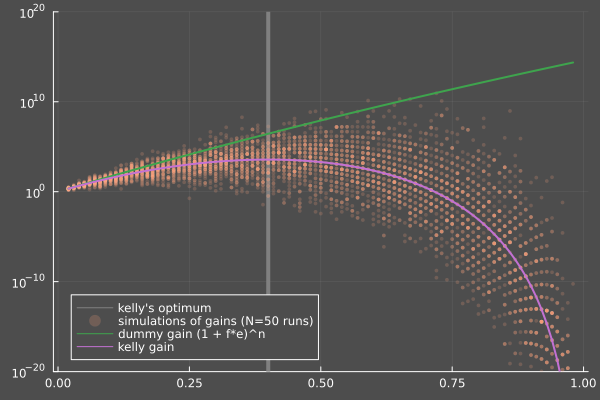

In [22]:
function g(f,p,a,b,n)
    gamma = (1 + f*a) / (1 - f*b)
    (1 - f*b)^n * gamma^(n*p) + 2
end

N_plot = Int(min(N,1000))

vline([f_kelly(p,a,b)], color=:gray, lw=4, label="kelly's optimum")

for f in f_list
    _label = f == f_list[1] ? "simulations of gains (N=$N runs)" : :none
    scatter!(f.*ones(N_plot), 
    D[f][end,1:N_plot], 
    color=:lightsalmon, 
    alpha=0.2, ms=2, 
    label=_label, 
    markerstrokewidth=0,
    foreground_color=:white, 
    background_color=:gray30)
end
#plot!(f_list, M3, fillrange=1e-20, label = "statistical maximal gain (1-δ = 99%)", color=:gray, alpha=0.3)
plot!(yscale=:log, ylims=(1e-20, 1e20), legend=:bottomleft)
plot!(ylims=(1e-20,1e20))
e = p*a - (1-p)*b
plot!(f_list, (1 .+ e.*f_list).^n , lw=2, label="dummy gain (1 + f*e)^n")
plot!(f_list, R.(f_list, p,a,b).^n, lw=2, label="kelly gain")



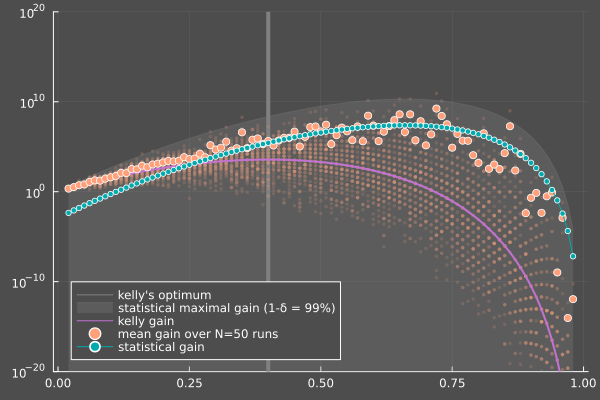

In [23]:

vline([f_kelly(p,a,b)], color=:gray, lw=4, label="kelly's optimum")
for f in f_list
    scatter!(f.*ones(N_plot), D[f][end,1:N_plot], color=:lightsalmon, alpha=0.2, ms=2, label=:none, markerstrokewidth=0)
end
plot!(f_list, M3, fillrange=1e-20, label = "statistical maximal gain (1-δ = 99%)", color=:gray, alpha=0.3)
plot!(yscale=:log, ylims=(1e-20, 1e20), legend=:bottomleft,foreground_color=:white, 
    background_color=:gray30)
plot!(ylims=(1e-20,1e20))
e = p*a - (1-p)*b
plot!(f_list, R.(f_list, p,a,b).^n, lw=2, label="kelly gain")

scatter!(f_list, M, color=:lightsalmon, label="mean gain over N=$N runs")
#plot!(f_list, M .+ σ, fillrange = M.-σ, color=:gray, alpha=0.2)
plot!(f_list, M2, markersize=3, markershape=:circle, label="statistical gain")


